In [1]:
"""
    Compare the class accuracies of two models
"""

'\n    Compare the class accuracies of two models\n'

In [2]:
import numpy as np
import pdb
# from mmaction.core import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
# plt.switch_backend('agg')

In [3]:
def confusion_matrix(y_pred, y_real, normalize=None):
    """Compute confusion matrix.

    Args:
        y_pred (list[int] | np.ndarray[int]): Prediction labels.
        y_real (list[int] | np.ndarray[int]): Ground truth labels.
        normalize (str | None): Normalizes confusion matrix over the true
            (rows), predicted (columns) conditions or all the population.
            If None, confusion matrix will not be normalized. Options are
            "true", "pred", "all", None. Default: None.

    Returns:
        np.ndarray: Confusion matrix.
    """
    if normalize not in ['true', 'pred', 'all', None]:
        raise ValueError("normalize must be one of {'true', 'pred', "
                         "'all', None}")

    if isinstance(y_pred, list):
        y_pred = np.array(y_pred)
    if not isinstance(y_pred, np.ndarray):
        raise TypeError(
            f'y_pred must be list or np.ndarray, but got {type(y_pred)}')
    if not y_pred.dtype == np.int64:
        raise TypeError(
            f'y_pred dtype must be np.int64, but got {y_pred.dtype}')

    if isinstance(y_real, list):
        y_real = np.array(y_real)
    if not isinstance(y_real, np.ndarray):
        raise TypeError(
            f'y_real must be list or np.ndarray, but got {type(y_real)}')
    if not y_real.dtype == np.int64:
        raise TypeError(
            f'y_real dtype must be np.int64, but got {y_real.dtype}')

    label_set = np.unique(np.concatenate((y_pred, y_real)))
    num_labels = len(label_set)
    label_map = {label: i for i, label in enumerate(label_set)}
    confusion_mat = np.zeros((num_labels, num_labels), dtype=np.int64)
    for rlabel, plabel in zip(y_real, y_pred):
        index_real = label_map[rlabel]
        index_pred = label_map[plabel]
        confusion_mat[index_real][index_pred] += 1

    with np.errstate(all='ignore'):
        if normalize == 'true':
            confusion_mat = (
                confusion_mat / confusion_mat.sum(axis=1, keepdims=True))
        elif normalize == 'pred':
            confusion_mat = (
                confusion_mat / confusion_mat.sum(axis=0, keepdims=True))
        elif normalize == 'all':
            confusion_mat = (confusion_mat / confusion_mat.sum())
        confusion_mat = np.nan_to_num(confusion_mat)

    return confusion_mat

In [4]:
# set up path for thh reference (baseline) model prediction and its ground truth
# The reason why we have two different ground truth is that the orders could be different across different machines
# ref_prediction_path = '../../work_dirs/r2plus1d_r34_video_8x8x1_180e_ucf101_rgb_fixmatch_20percent_vidssl/results.pkl'
# ref_prediction_path = '../../work_dirs/r2plus1d_r34_video_3d_8x8x1_900e_ucf101_rgb_20percent_vidssl/results.pkl'
# ref_gt_labels_path = '../../work_dirs/r2plus1d_r34_video_8x8x1_180e_ucf101_rgb_fixmatch_20percent_vidssl/gt_labels.npy'
ref_prediction_path = '../../work_dirs/r2plus1d_r34_video_8x8x1_360e_ucf101_rgb_all_20percent_vidssl/results.pkl' # final model, CVPR
ref_gt_labels_path = '../../work_dirs/r2plus1d_r34_video_3d_8x8x1_900e_ucf101_rgb_20percent_vidssl/gt_labels_new.npy'


# class names 
classnames_path = '../../work_dirs/r2plus1d_r34_video_8x8x1_180e_ucf101_rgb_fixmatch_20percent_vidssl/classnames.npy'

# set up the path for the compared (proposed) model predictions, and its ground truth
# comp_prediction_path = '../../work_dirs/r2plus1d_r34_video_8x8x1_180e_ucf101_rgb_all_20percent_vidssl/results.pkl'
# comp_prediction_path = '../../work_dirs/r2plus1d_r34_video_8x8x1_180e_ucf101_rgb_actorcutmix_20percent_vidssl/results.pkl'
# comp_prediction_path = '../../work_dirs/r2plus1d_r34_video_8x8x1_180e_ucf101_rgb_actorcutmix_randaug_20percent_vidssl/results.pkl'

comp_prediction_path = '../../work_dirs/r2plus1d_r34_video_8x8x1_45e_ucf101-kinetics100_rgb_all_full_vidssl_1GPU/results.pkl' # final model
comp_gt_labels_path = '../../work_dirs/r2plus1d_r34_video_3d_8x8x1_900e_ucf101_rgb_20percent_vidssl/gt_labels_new.npy'
# comp_prediction_path = '../../work_dirs/r2plus1d_r34_video_8x8x1_360e_ucf101_rgb_all_20percent_vidssl/results.pkl'
# comp_gt_labels_path = '../../work_dirs/r2plus1d_r34_video_3d_8x8x1_900e_ucf101_rgb_20percent_vidssl/gt_labels_new.npy'
# comp_gt_labels_path = '../../work_dirs/r2plus1d_r34_video_8x8x1_180e_ucf101_rgb_actorcutmix_randaug_20percent_vidssl/results_gt.pkl'


# set up the output bar chart path for both worse classes and better classes
output_bar_chart_path_worse = '../../work_dirs/compare_{}_{}_bar_worse.jpg'.format(ref_prediction_path.split('/')[-2], comp_prediction_path.split('/')[-2])
output_bar_chart_path_better = '../../work_dirs/compare_{}_{}_bar_better.jpg'.format(ref_prediction_path.split('/')[-2], comp_prediction_path.split('/')[-2])

# how many err classes to visualize
top_k = 5

In [5]:
# read the data
ref_preds = np.load(ref_prediction_path, allow_pickle=True)
ref_preds = [entry.argmax() for entry in ref_preds]
comp_preds = np.load(comp_prediction_path, allow_pickle=True)
comp_preds = [entry.argmax() for entry in comp_preds]
ref_gt_labels = np.load(ref_gt_labels_path)
comp_gt_labels = np.array(np.load(comp_gt_labels_path, allow_pickle=True))
classnames = np.load(classnames_path)

In [6]:
# compute ref model confmat, top-1 accuracy, mean class accuracy, mean class error rate
confmat_ref = confusion_matrix(ref_preds, ref_gt_labels)
ref_overall_acc = np.sum(np.diag(confmat_ref))/float(len(ref_gt_labels))
print('Ref pred top-1 accuracy: {:.2f}%'.format(100*ref_overall_acc))
ref_class_accs = np.diag(confmat_ref)/np.sum(confmat_ref, axis=1)
print('Ref mean class accuracy: {:.2f}%'.format(100*np.mean(ref_class_accs)))
ref_class_err = 1-ref_class_accs
print('Ref mean class error rate: {:.2f}%'.format(100*np.mean(ref_class_err)))
confmat_norm_ref = confmat_ref/ np.sum(confmat_ref, axis=1)[:,None]

# compute compared model confmat, top-1 accuracy, mean class accuracy, mean class error rate
# confmat_comp = confusion_matrix(comp_preds, comp_gt_labels[:,1].astype(int))
confmat_comp = confusion_matrix(comp_preds, comp_gt_labels)
comp_overall_acc = np.sum(np.diag(confmat_comp))/float(len(comp_gt_labels))
print('Compared pred accuracy: {:.2f}%'.format(100*comp_overall_acc))
comp_class_accs = np.diag(confmat_comp)/np.sum(confmat_comp, axis=1)
print('Compared mean class accuracy: {:.2f}%'.format(100*np.mean(comp_class_accs)))
comp_class_err = 1-comp_class_accs
print('Compared mean class error rate: {:.2f}%'.format(100*np.mean(comp_class_err)))
confmat_norm_comp = confmat_comp/ np.sum(confmat_comp, axis=1)[:,None]

Ref pred top-1 accuracy: 56.73%
Ref mean class accuracy: 56.49%
Ref mean class error rate: 43.51%
Compared pred accuracy: 63.26%
Compared mean class accuracy: 63.32%
Compared mean class error rate: 36.68%


In [7]:
# get the difference between compared models' class accs and reference models' class accs
acc_diff = comp_class_accs - ref_class_accs 
# sort the difference ascending order
sorted_idx = acc_diff.argsort()

# get the classes where compared model shows worse accuracies
worse_data = acc_diff[sorted_idx][acc_diff[sorted_idx]<0]
worse_class_err = comp_class_err[sorted_idx][acc_diff[sorted_idx]<0]
print('mean class error rate of the compared models, worse classes only: {:.2f}%'.format(100*np.mean(worse_class_err)))
worse_classes = classnames[sorted_idx][acc_diff[sorted_idx]<0]
print('there are {} worse classes'.format(worse_classes.shape[0]))
worse_range = np.arange(len(worse_data))

# Get top-k+1 class names by the compared method
missclassified = classnames[ (-confmat_comp[sorted_idx,:]).argsort(axis=1) ][:,:top_k+1][acc_diff[sorted_idx]<0]
# confmat_comp[sorted_idx,:] # -> confmat rows are sorted according to the order of increasing the class diff between the comp model and ref model
# (-confmat_comp[sorted_idx,:]).argsort()  # confmat columns are sorted according to the descending order of elements
# classnames[ (-confmat_comp[sorted_idx,:]).argsort(axis=1) ][:,:top_k+1] # confmat columns are selected top-(k+1) elements
# classnames[ (-confmat_comp[sorted_idx,:]).argsort(axis=1) ][:,:top_k+1][acc_diff[sorted_idx]<0] # confmat columns are selected top-(k+1) elements and then rows are selected only for the worse classes and the class names are selected according to those confmat element

# Get top-5 classes missclassified by the compared methods
filt_missclassified = []
for cur_cls,entry in zip(worse_classes,missclassified):
    filt_missclassified.append(entry[cur_cls!=entry][:top_k])
filt_missclassified = np.array(filt_missclassified)

better_data = acc_diff[sorted_idx][acc_diff[sorted_idx]>=0]
better_class_err = comp_class_err[sorted_idx][acc_diff[sorted_idx]>=0]
print('mean class error rate of the compared models, better classes only: {:.2f}%'.format(100*np.mean(better_class_err)))
better_classes = classnames[sorted_idx][acc_diff[sorted_idx]>=0]
print('there are {} better classes'.format(better_classes.shape[0]))
better_range = np.arange(len(better_data))

# Get top-k+1 class names by the reference method
ref_missclassified = classnames[ (-confmat_ref[sorted_idx,:]).argsort(axis=1) ][:,:top_k+1][acc_diff[sorted_idx]>=0]

# Get top-5 classes missclassified by the reference methods
ref_filt_missclassified = []
for cur_cls,entry in zip(better_classes,ref_missclassified):
    ref_filt_missclassified.append(entry[cur_cls!=entry][:top_k])
ref_filt_missclassified = np.array(ref_filt_missclassified)

mean class error rate of the compared models, worse classes only: 53.44%
there are 28 worse classes
mean class error rate of the compared models, better classes only: 30.26%
there are 73 better classes


In [8]:
# Compute class-wise error rates for the compared model
np.fill_diagonal(confmat_norm_comp, 0)
err_sorted_idx = (-confmat_norm_comp[sorted_idx][acc_diff[sorted_idx]<0]).argsort(axis=1)
err_rates_top_k = []
for i,(row) in enumerate(confmat_norm_comp[sorted_idx][acc_diff[sorted_idx]<0]):        
    err_rates_top_k.append(row[err_sorted_idx[i,:top_k]])    
err_rates_top_k = np.array(err_rates_top_k)

# Compute accumulated class-wise error rates (top-k)
err_rates_top_k_T_acc = []
for i,row in enumerate(err_rates_top_k.T):
    if i==0:
        err_rates_top_k_T_acc.append(row)
    else:
        new_row = err_rates_top_k_T_acc[i-1]+ row
        err_rates_top_k_T_acc.append(new_row)

In [9]:
# Compute class-wise error rates for the reference model
np.fill_diagonal(confmat_norm_ref, 0)
ref_err_sorted_idx = (-confmat_norm_ref[sorted_idx][acc_diff[sorted_idx]>=0]).argsort(axis=1)
ref_err_rates_top_k = []
for i,(row) in enumerate(confmat_norm_ref[sorted_idx][acc_diff[sorted_idx]>=0]):        
    ref_err_rates_top_k.append(row[ref_err_sorted_idx[i,:top_k]])    
ref_err_rates_top_k = np.array(ref_err_rates_top_k)

# Compute accumulated class-wise error rates (top-k)
ref_err_rates_top_k_T_acc = []
for i,row in enumerate(ref_err_rates_top_k.T):
    if i==0:
        ref_err_rates_top_k_T_acc.append(row)
    else:
        new_row = ref_err_rates_top_k_T_acc[i-1]+ row
        ref_err_rates_top_k_T_acc.append(new_row)

In [10]:
def autolabel(rects, labels, ax, k):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect, label in zip(rects, labels):
        width = rect.get_width()     
        ax.annotate('{}'.format(label),
                    xy=(0.03+0.2*k, rect.get_y()),
                    xytext=(0, 5),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='right', va='baseline')

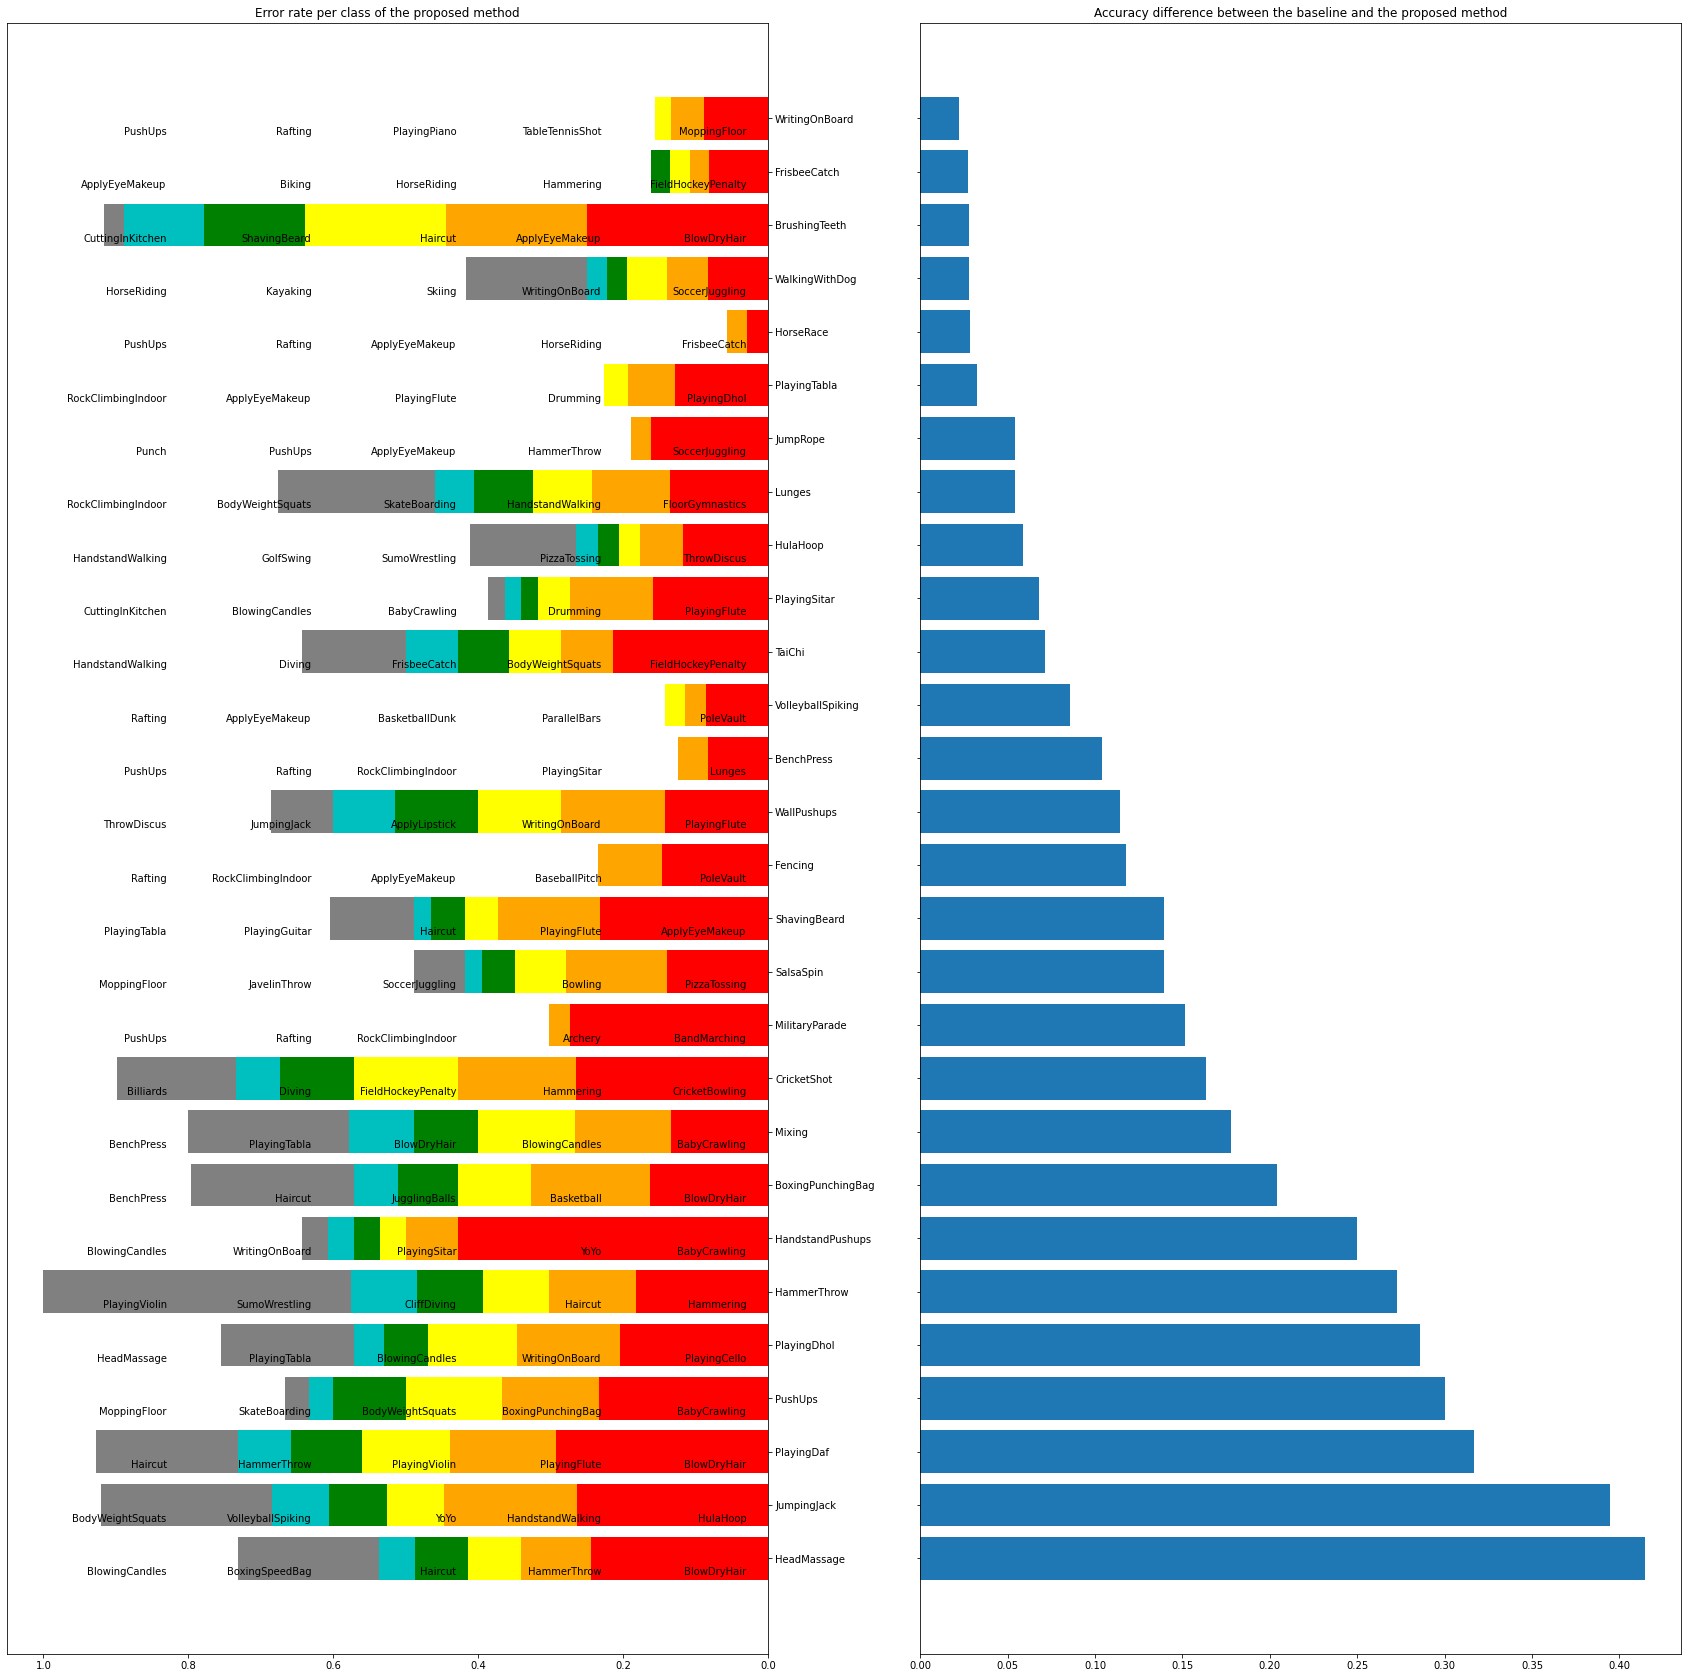

In [11]:
r = np.arange(0,2*len(classnames),2)
barWidth = 0.8

# worse classes
figure, axes = plt.subplots(ncols=2, figsize=[30,30], sharey=True)
rects = axes[0].barh(worse_range, worse_class_err, height=barWidth,zorder=-10, color='grey')
axes[0].set(title='Error rate per class of the proposed method')
# autolabel(rects, filt_missclassified, axes[0])

colors = ['r', 'orange', 'yellow', 'g', 'c']
for i,(color,cur_errs) in enumerate(zip(colors,err_rates_top_k_T_acc)):
    cur_rect = axes[0].barh(worse_range, cur_errs, height=barWidth, zorder=-i, color=color)
    autolabel(cur_rect, filt_missclassified[:,i], axes[0], i)
    
axes[1].barh(worse_range, -worse_data, height=barWidth)
axes[1].set(title='Accuracy difference between the baseline and the proposed method')

axes[0].invert_xaxis()
axes[0].set(yticks=worse_range, yticklabels=worse_classes)
axes[0].yaxis.tick_right()

plt.show()
figure.savefig(output_bar_chart_path_worse,  bbox_inches='tight') 

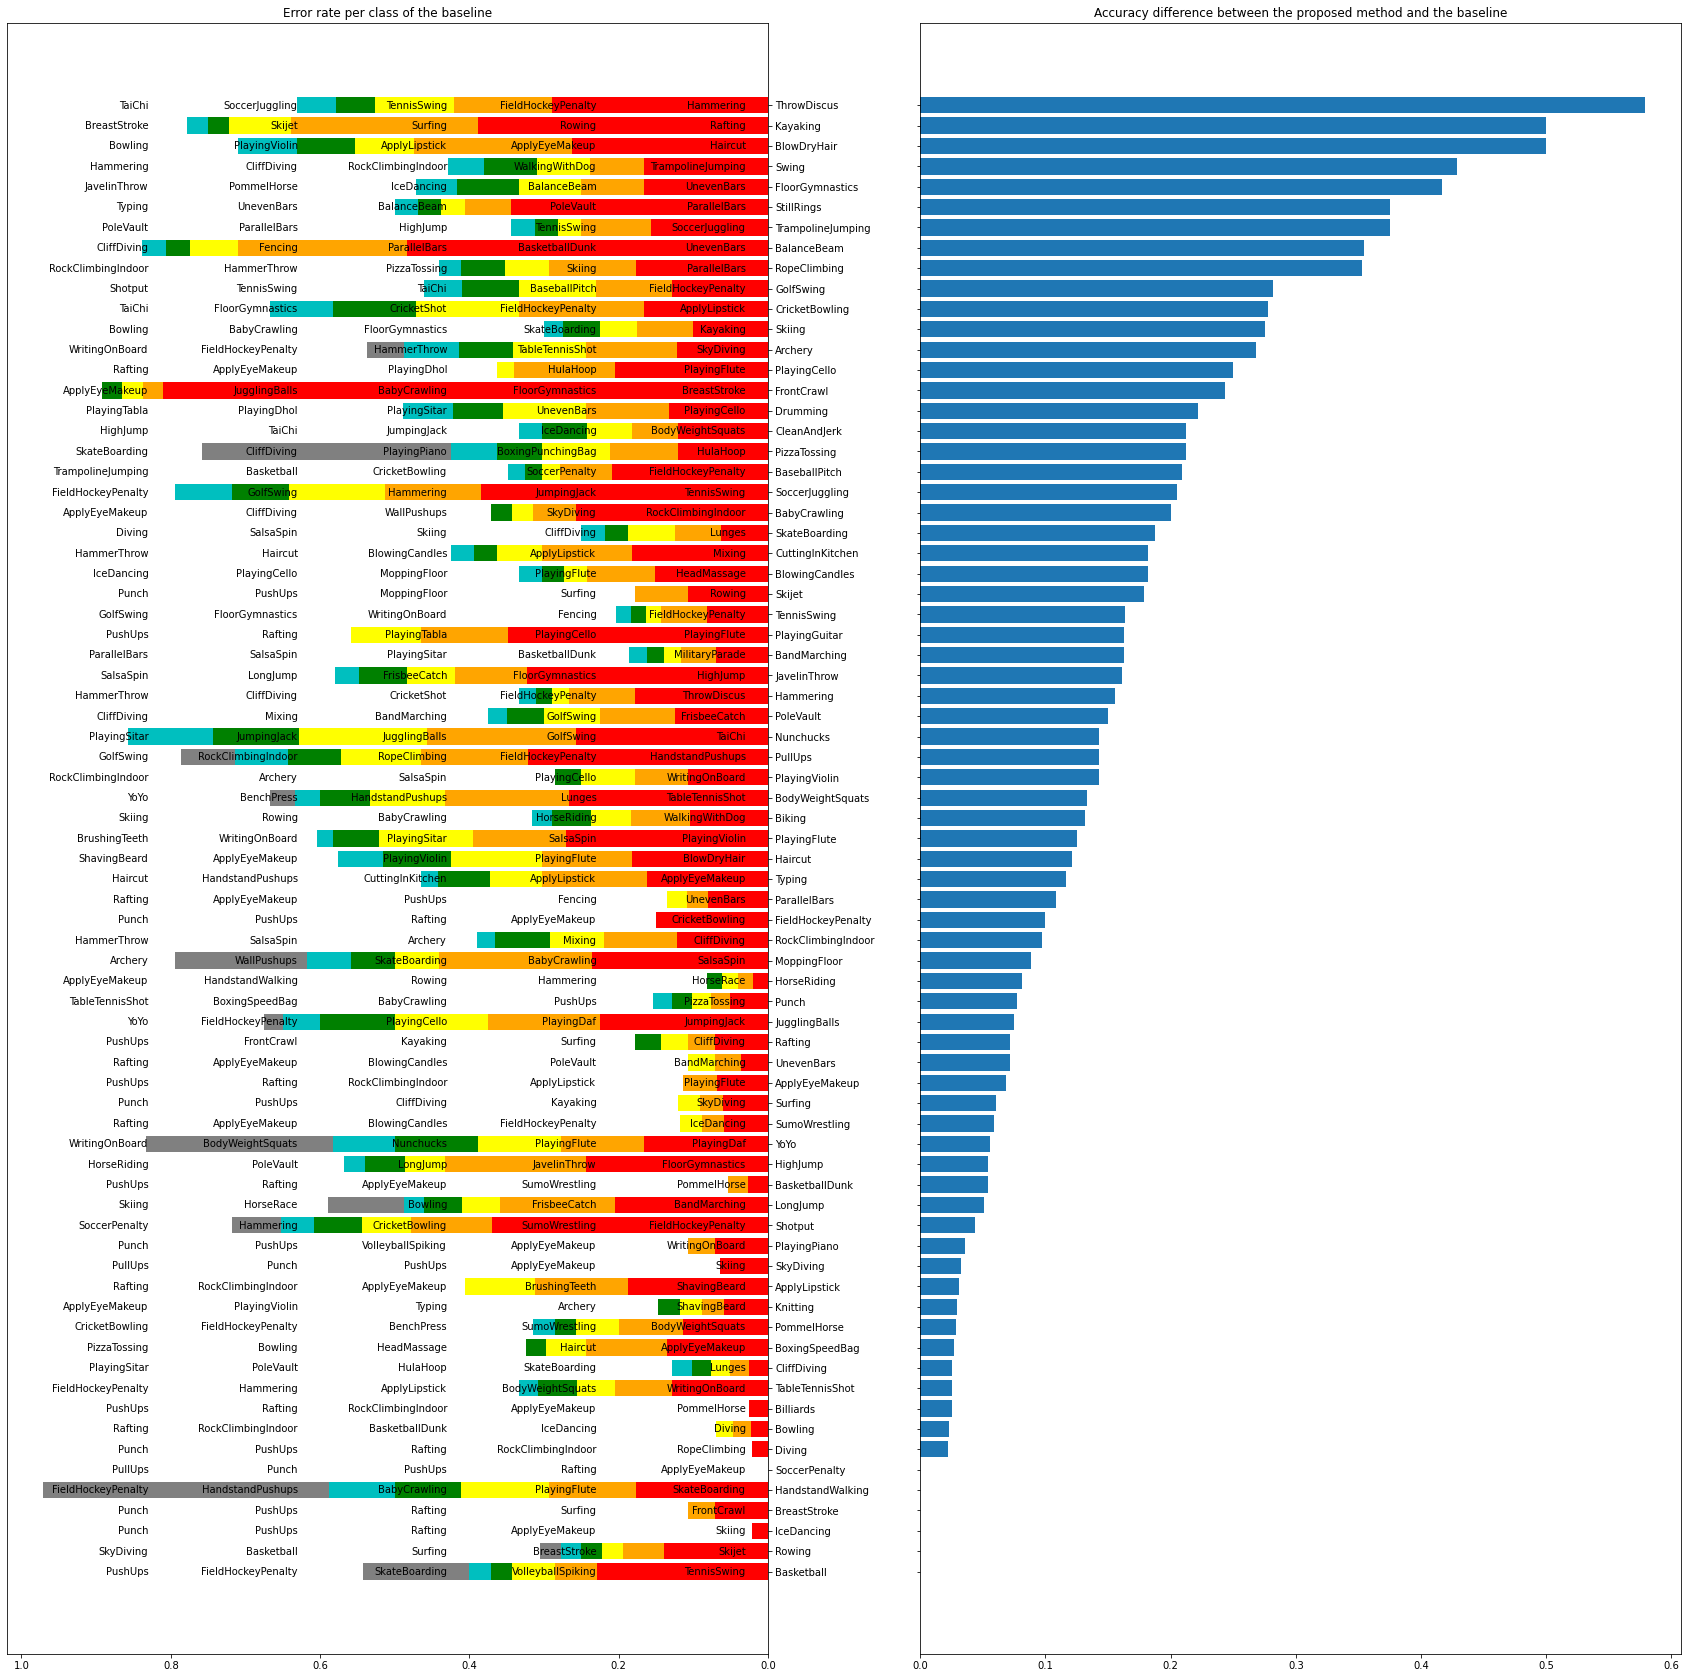

In [12]:
r = np.arange(0,2*len(classnames),2)
barWidth = 0.8

# better classes
figure, axes = plt.subplots(ncols=2, figsize=[30,30], sharey=True)
rects = axes[0].barh(better_range, better_class_err, height=barWidth,zorder=-10, color='grey')
axes[0].set(title='Error rate per class of the baseline')
# autolabel(rects, filt_missclassified, axes[0])

colors = ['r', 'orange', 'yellow', 'g', 'c']
for i,(color,cur_errs) in enumerate(zip(colors,ref_err_rates_top_k_T_acc)):
    cur_rect = axes[0].barh(better_range, cur_errs, height=barWidth, zorder=-i, color=color)
    autolabel(cur_rect, ref_filt_missclassified[:,i], axes[0], i)
    
axes[1].barh(better_range, better_data, height=barWidth)
axes[1].set(title='Accuracy difference between the proposed method and the baseline')

axes[0].invert_xaxis()
axes[0].set(yticks=better_range, yticklabels=better_classes)
axes[0].yaxis.tick_right()

plt.show()
figure.savefig(output_bar_chart_path_better,  bbox_inches='tight') 

In [14]:
from moviepy.editor import *  
import os
import pandas as pd

In [138]:
videos_root = '/home/jinchoi/src/rehab/dataset/action/UCF101/UCF101_videos'
listfile_path = '/home/jinchoi/src/video-data-aug/data/ucf101/ucf101_val_split_1_rawframes.txt'

In [139]:
df = pd.read_csv(listfile_path, sep=' ', header=None)
if np.array_equal(df.values[:,2],gt_labels):
    print("Sanity check the GT/prediction order with the listfile: True")
else:
    print("Sanity check the GT/prediction order with the listfile: False!!!!!")

Sanity check the GT/prediction order with the listfile: False!!!!!


In [22]:
for i,(cur_pred,gt,vid) in enumerate(zip(comp_preds,gt_labels,df[0].values)):
    cur_vid_path = os.path.join(videos_root, vid + '.avi')
    clip = VideoFileClip(os.path.join(cur_vid_path))
    print('current prediction/gt: {}/{}'.format(classnames[cur_pred], classnames[gt]))
    if classnames[gt]=='Typing':
        clip.ipython_display()
        break

current prediction/gt: PlayingViolin/PlayingViolin
current prediction/gt: WalkingWithDog/SoccerJuggling
current prediction/gt: Bowling/Bowling
current prediction/gt: PommelHorse/Drumming
current prediction/gt: HeadMassage/HammerThrow
current prediction/gt: FloorGymnastics/MoppingFloor
current prediction/gt: Diving/PlayingSitar
current prediction/gt: RockClimbingIndoor/BrushingTeeth
current prediction/gt: SalsaSpin/MoppingFloor
current prediction/gt: ParallelBars/ParallelBars
current prediction/gt: StillRings/StillRings
current prediction/gt: PlayingCello/Mixing
current prediction/gt: HandstandPushups/PlayingCello
current prediction/gt: WritingOnBoard/WritingOnBoard
current prediction/gt: PlayingViolin/BodyWeightSquats
current prediction/gt: PlayingCello/PlayingGuitar
current prediction/gt: Surfing/Surfing
current prediction/gt: PlayingFlute/BrushingTeeth
current prediction/gt: FieldHockeyPenalty/FieldHockeyPenalty
current prediction/gt: BalanceBeam/FloorGymnastics
current prediction/gt

chunk:  57%|█████▋    | 125/221 [00:00<00:00, 1239.33it/s, now=None]

current prediction/gt: PlayingFlute/Typing
Moviepy - Building video __temp__.mp4.
MoviePy - Writing audio in __temp__TEMP_MPY_wvf_snd.mp3


t:  54%|█████▍    | 136/250 [00:00<00:00, 1356.97it/s, now=None]    

MoviePy - Done.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [23]:
print('current prediction/gt: {}/{}'.format(classnames[cur_pred], classnames[gt]))

current prediction/gt: PlayingFlute/Typing


In [24]:
clip.ipython_display()

chunk:  15%|█▌        | 34/221 [00:00<00:00, 339.74it/s, now=None]

Moviepy - Building video __temp__.mp4.
MoviePy - Writing audio in __temp__TEMP_MPY_wvf_snd.mp3


t:   5%|▍         | 12/250 [00:00<00:02, 115.19it/s, now=None]     

MoviePy - Done.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [ ]:
# def autolabel(rects, labels, ax):
#     """Attach a text label above each bar in *rects*, displaying its height."""
#     for rect, label in zip(rects, labels):
#         width = rect.get_width()     
#         ax.annotate('{}'.format(' / '.join(label)),
#                     xy=(0.01, rect.get_y()),
#                     xytext=(0, 5),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='left', va='bottom')

In [ ]:
# # worse classes
# figure, axes = plt.subplots(ncols=2, figsize=[30,30], sharey=True)
# rects = axes[0].barh(worse_range, worse_class_err, height=barWidth)
# axes[0].set(title='Error rate per class')

# rects = axes[1].barh(worse_range, -worse_data, height=barWidth)
# axes[1].set(title='Accuracy difference between the baseline and the proposed method')

# axes[0].invert_xaxis()
# axes[0].set(yticks=worse_range, yticklabels=worse_classes)

# # axes[0].set_ylabel("class names")
# axes[0].yaxis.tick_right()

# autolabel(rects, filt_missclassified, axes[1])
# plt.show()
# figure.savefig(output_bar_chart_path_worse,  bbox_inches='tight') 